# Importation des bibliothèques

In [32]:
import numpy as np
import pandas as pd


import re
import spacy
import fr_core_news_sm
from nltk.stem import PorterStemmer 
from nltk.tokenize import word_tokenize 
from nltk.corpus import stopwords

from sklearn.datasets import load_files
import pickle
import sklearn.externals as extjoblib
import joblib


from sklearn.preprocessing import FunctionTransformer

from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.multioutput import MultiOutputClassifier
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split, GridSearchCV

from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier


import sklearn.metrics

import matplotlib.pyplot as plt
import seaborn as sns

# Chargement des données

In [2]:
#DONNEE BRUTE

df = pd.read_excel("C:/Users/ET03349/Desktop/Sémantique/Lot_voix_ca/labels-voix-ca-lot-7.xlsx")
df = df[['text', 'category', 'is_project']]

In [3]:
df

,text,category,is_project
0,simul pret auto pour un montant de 5 000 euros...,Montant,False
1,simul pret auto pour un montant de 5 000 euros...,Credit_vehicule,True
2,azo le 22 novembre message laisser laisser,Date,False
3,j'ai vu monsieur ce jour premier contact avec...,Date,False
4,j'ai vu monsieur ce jour premier contact avec...,Bilan_suivi_relationnel,False
...,...,...,...
8811,j'ai vu ce jour prévoyance obsèques de 3000...,Date,False
8812,j'ai vu ce jour prévoyance obsèques de 3000...,Assurance_de_Personnes,True
8813,j'ai vu ce jour prévoyance obsèques de 3000...,Date,False
8814,j'ai vu ce jour prévoyance obsèques de 3000...,Point_d_attention_risques,False


In [4]:
df.category.describe

<bound method NDFrame.describe of 0                         Montant
1                 Credit_vehicule
2                            Date
3                            Date
4         Bilan_suivi_relationnel
                  ...            
8811                         Date
8812       Assurance_de_Personnes
8813                         Date
8814    Point_d_attention_risques
8815    Point_d_attention_risques
Name: category, Length: 8816, dtype: object>

# Visualisation de donnée

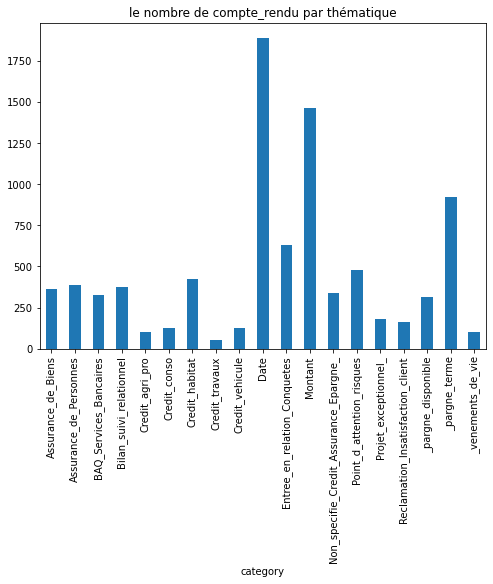

In [5]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(8,6))
plt.title("le nombre de compte_rendu par thématique")
df.groupby('category').text.count().plot.bar(ylim=0)
plt.show()

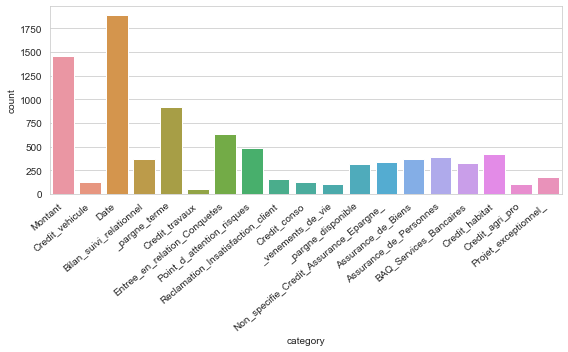

In [6]:
sns.set_style('whitegrid')
plt.figure(figsize=(8, 5))
ax = sns.countplot(x='category', data=df)
ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")
plt.tight_layout()

In [7]:
#Nombre de comptes rendus en fonction des thématiques
print(pd.crosstab(index=df["category"],columns="count"))

col_0                                   count
category                                     
Assurance_de_Biens                        364
Assurance_de_Personnes                    387
BAQ_Services_Bancaires                    328
Bilan_suivi_relationnel                   373
Credit_agri_pro                           104
Credit_conso                              127
Credit_habitat                            427
Credit_travaux                             51
Credit_vehicule                           127
Date                                     1887
Entree_en_relation_Conquetes              631
Montant                                  1462
Non_specifie_Credit_Assurance_Epargne_    337
Point_d_attention_risques                 481
Projet_exceptionnel_                      183
Reclamation_Insatisfaction_client         160
_pargne_disponible                        316
_pargne_terme                             921
_venements_de_vie                         100


# Encoding dataframe

In [9]:
       df_s = df.groupby(['text', 'category'])['is_project'].first().unstack(-1)
       df_s = (~df_s.isna()).astype(int)

       # Les noms des colonnes cibles
       category_cols = [
              'Credit_vehicule', 'Bilan_suivi_relationnel',
             '_pargne_terme', 
             #'Credit_travaux', 
             'Entree_en_relation_Conquetes',
             'Point_d_attention_risques', 'Reclamation_Insatisfaction_client',
             'Credit_conso', 
             #'_venements_de_vie','Credit_agri_pro',
              '_pargne_disponible',
              'Non_specifie_Credit_Assurance_Epargne_', 'Assurance_de_Biens',
             'Assurance_de_Personnes', 'BAQ_Services_Bancaires',
              'Credit_habitat',  'Projet_exceptionnel_']

df_s = df_s.reset_index()

In [10]:
print("Number of rows in data =",df_s.shape[0])
print("Number of columns in data =",df_s.shape[1])
print("\n")
print("**Sample data:**")
df_s.head()

Number of rows in data = 1443
Number of columns in data = 20


**Sample data:**


category,text,Assurance_de_Biens,Assurance_de_Personnes,BAQ_Services_Bancaires,Bilan_suivi_relationnel,Credit_agri_pro,Credit_conso,Credit_habitat,Credit_travaux,Credit_vehicule,Date,Entree_en_relation_Conquetes,Montant,Non_specifie_Credit_Assurance_Epargne_,Point_d_attention_risques,Projet_exceptionnel_,Reclamation_Insatisfaction_client,_pargne_disponible,_pargne_terme,_venements_de_vie
0,\t\n15/05/2019\nENVOI SOUSCRIPTION PSV MAIL\nM...,0,0,0,1,0,0,0,0,0,1,1,0,0,0,0,0,0,1,0
1,\n appel au client aujourd'hui suite à un mail...,0,0,1,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0
2,\n attente des documents pour deux ouverture d...,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
3,\n entretien avec Madame pour un projet d'une ...,0,0,0,0,0,0,1,0,0,0,0,1,0,1,0,0,0,1,0
4,\n le client a placé sur son assurance 20 000 ...,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0


# Suppresion collonne peut/trop représenter

In [11]:
df_s = df_s.drop(['Montant','Date', 'Credit_agri_pro', 'Credit_travaux', '_venements_de_vie'], axis = 1)
df_s.head()

category,text,Assurance_de_Biens,Assurance_de_Personnes,BAQ_Services_Bancaires,Bilan_suivi_relationnel,Credit_conso,Credit_habitat,Credit_vehicule,Entree_en_relation_Conquetes,Non_specifie_Credit_Assurance_Epargne_,Point_d_attention_risques,Projet_exceptionnel_,Reclamation_Insatisfaction_client,_pargne_disponible,_pargne_terme
0,\t\n15/05/2019\nENVOI SOUSCRIPTION PSV MAIL\nM...,0,0,0,1,0,0,0,1,0,0,0,0,0,1
1,\n appel au client aujourd'hui suite à un mail...,0,0,1,0,0,0,0,0,0,0,0,0,0,0
2,\n attente des documents pour deux ouverture d...,0,0,0,0,0,0,0,1,0,0,0,0,0,0
3,\n entretien avec Madame pour un projet d'une ...,0,0,0,0,0,1,0,0,0,1,0,0,0,1
4,\n le client a placé sur son assurance 20 000 ...,0,0,0,0,0,0,0,0,0,0,0,0,0,1


# Prepross texte

In [12]:
df_s.text = df_s.text.astype(str)

In [13]:
transformer = FunctionTransformer()
transformer.transform(df_s['text'])

0       \t\n15/05/2019\nENVOI SOUSCRIPTION PSV MAIL\nM...
1       \n appel au client aujourd'hui suite à un mail...
2       \n attente des documents pour deux ouverture d...
3       \n entretien avec Madame pour un projet d'une ...
4       \n le client a placé sur son assurance 20 000 ...
                              ...                        
1438      vu pour projet locatif. Devis futur  PPNO fait.
1439    vu sonia 17/07/2019 à la dde du client questio...
1440                      à rapp car fonds sur le compte 
1441    échange rapide par téléphone ce jour avec Mons...
1442    échange téléphonique ce jour avec monsieur.   ...
Name: text, Length: 1443, dtype: object

In [14]:
# Chargement stopwords français
stop_words = stopwords.words('french')
    
# Initialize stemmer, which will take words and convert words to their "stem," e.g. Playing-> Play
ps = PorterStemmer() 

# Enlever les charactères nons alphabétiques, espaces et convertir toutes les lettres en minuscules
# References: https://www.analyticsvidhya.com/blog/2019/04/predicting-movie-genres-nlp-multi-label-classification/
def clean_text(txt): 
    txt = txt.lower()   #lowercase
    txt = re.sub("[^a-zA-Z]"," ",txt) #Remove everything except alphabetical characters 
    txt = word_tokenize(txt) #tokenize (split into list and remove whitespace)
    
    #initialize list to store clean text
    clean_text=""
      
    #iterate over each word
    for w in txt:      
        #remove stopwords
        if w not in stop_words:
            #stem=ps.stem(w) #stem 
            stem = w
            clean_text += stem +" " 
    return clean_text


text_new =[] #declare a list to hold new movies

for cell in df_s['text']:    
    txt = clean_text(cell)
    text_new.append(txt)
    
#add new info column to the dataframe
df_s['text'] = text_new 
df_s.head(1)


category,text,Assurance_de_Biens,Assurance_de_Personnes,BAQ_Services_Bancaires,Bilan_suivi_relationnel,Credit_conso,Credit_habitat,Credit_vehicule,Entree_en_relation_Conquetes,Non_specifie_Credit_Assurance_Epargne_,Point_d_attention_risques,Projet_exceptionnel_,Reclamation_Insatisfaction_client,_pargne_disponible,_pargne_terme
0,envoi souscription psv mail mv eai traitement ...,0,0,0,1,0,0,0,1,0,0,0,0,0,1


In [15]:
import nltk
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer
import re
import sys
import warnings

data = df_s

if not sys.warnoptions:
    warnings.simplefilter("ignore")
def cleanHtml(sentence):
    cleanr = re.compile('<.*?>')
    cleantext = re.sub(cleanr, ' ', str(sentence))
    return cleantext

def cleanPunc(sentence): #function to clean the word of any punctuation or special characters
    cleaned = re.sub(r'[?|!|\'|"|#]', r' ',sentence)
    cleaned = re.sub(r'[.|,|)|(|\|/]', r' ',cleaned)
    cleaned = cleaned.strip()
    cleaned = cleaned.replace("\n", " ")
    return cleaned

def keepAlpha(sentence):
    alpha_sent = ""
    for word in sentence.split():
        alpha_word = re.sub('[^a-z A-Z]+', ' ', word)
        alpha_sent += alpha_word
        alpha_sent += " "
    alpha_sent = alpha_sent.strip()
    return alpha_sent

data['text'] = data['text'].str.lower()
data['text'] = data['text'].apply(cleanHtml)
data['text'] = data['text'].apply(cleanPunc)
data['text'] = data['text'].apply(keepAlpha)

In [16]:
stop_words = set(stopwords.words('english'))
re_stop_words = re.compile(r"\b(" + "|".join(stop_words) + ")\\W", re.I)

def removeStopWords(sentence):
    global re_stop_words
    return re_stop_words.sub(" ", sentence)
data['text'] = data['text'].apply(removeStopWords)

In [17]:
stemmer = SnowballStemmer("french")

def stemming(sentence):
    stemSentence = ""
    for word in sentence.split():
        stem = stemmer.stem(word)
        stemSentence += stem
        stemSentence += " "
    stemSentence = stemSentence.strip()
    return stemSentence
data['text'] = data['text'].apply(stemming)

In [18]:
data.shape

(1443, 15)

# Modele

In [46]:
pipe = make_pipeline(
    CountVectorizer(),
    TfidfTransformer(),
    # Pour gérer les cas multi-label
    MultiOutputClassifier(
    # Le solveur par defaut est lent dans le cas sparse
       estimator=LogisticRegression(solver='liblinear')
    )
)

pipe.fit(data["text"], df_s[category_cols])

Pipeline(steps=[('countvectorizer', CountVectorizer()),
                ('tfidftransformer', TfidfTransformer()),
                ('multioutputclassifier',
                 MultiOutputClassifier(estimator=LogisticRegression(solver='liblinear')))])

In [47]:
pipe_linear = make_pipeline(
    CountVectorizer(),
    TfidfTransformer(),
    # Pour gérer les cas multi-label
    MultiOutputClassifier(
    # Le solveur par defaut est lent dans le cas sparse
       estimator=LogisticRegression(solver='liblinear')
    )
)

pipe_linear.fit(data["text"], df_s[category_cols])

Pipeline(steps=[('countvectorizer', CountVectorizer()),
                ('tfidftransformer', TfidfTransformer()),
                ('multioutputclassifier',
                 MultiOutputClassifier(estimator=LogisticRegression(solver='liblinear')))])

In [21]:
pipe_neighbors = make_pipeline(
    CountVectorizer(),
    TfidfTransformer(),
    # Pour gérer les cas multi-label
    MultiOutputClassifier(
    # Le solveur par defaut est lent dans le cas sparse
       estimator=KNeighborsClassifier(n_neighbors=3)
    )
)

pipe_neighbors.fit(data["text"], df_s[category_cols])

Pipeline(steps=[('countvectorizer', CountVectorizer()),
                ('tfidftransformer', TfidfTransformer()),
                ('multioutputclassifier',
                 MultiOutputClassifier(estimator=KNeighborsClassifier(n_neighbors=3)))])

In [24]:
pipe_MLPC = make_pipeline(
    CountVectorizer(),
    TfidfTransformer(),
    # Pour gérer les cas multi-label
    MultiOutputClassifier(
    # Le solveur par defaut est lent dans le cas sparse
       estimator=MLPClassifier(random_state=1, max_iter=300)
    )
)

pipe_MLPC.fit(data['text'], df_s[category_cols])

Pipeline(steps=[('countvectorizer', CountVectorizer()),
                ('tfidftransformer', TfidfTransformer()),
                ('multioutputclassifier',
                 MultiOutputClassifier(estimator=MLPClassifier(max_iter=300,
                                                               random_state=1)))])

In [23]:
pipe_decision_tree = make_pipeline(
    CountVectorizer(),
    TfidfTransformer(),
    # Pour gérer les cas multi-label
    MultiOutputClassifier(
    # Le solveur par defaut est lent dans le cas sparse
       estimator=DecisionTreeClassifier(random_state=0)
    )
)

pipe_decision_tree.fit(data["text"], df_s[category_cols])

Pipeline(steps=[('countvectorizer', CountVectorizer()),
                ('tfidftransformer', TfidfTransformer()),
                ('multioutputclassifier',
                 MultiOutputClassifier(estimator=DecisionTreeClassifier(random_state=0)))])

In [20]:
pipe_decision_tree2 = make_pipeline(
    CountVectorizer(),
    TfidfTransformer(),
    # Pour gérer les cas multi-label
    MultiOutputClassifier(
    # Le solveur par defaut est lent dans le cas sparse
       estimator=DecisionTreeClassifier(max_depth=121, min_samples_split=50, random_state=0)
    )
)

pipe_decision_tree2.fit(data["text"], df_s[category_cols])


Pipeline(steps=[('countvectorizer', CountVectorizer()),
                ('tfidftransformer', TfidfTransformer()),
                ('multioutputclassifier',
                 MultiOutputClassifier(estimator=DecisionTreeClassifier(max_depth=121,
                                                                        min_samples_split=50,
                                                                        random_state=0)))])

## train test

In [20]:
X_train, X_test, y_train, y_test = train_test_split(data['text'], df_s[category_cols], random_state = 0)

In [22]:
vectorizer = CountVectorizer()
X_train= vectorizer.fit_transform(X_train)


Tfidf = TfidfTransformer()
X_train = Tfidf.fit_transform(X_train)


In [74]:
pipe.fit(X_train, y_train)

Pipeline(steps=[('countvectorizer', CountVectorizer()),
                ('tfidftransformer', TfidfTransformer()),
                ('multioutputclassifier',
                 MultiOutputClassifier(estimator=LogisticRegression(solver='liblinear')))])

In [42]:
pipe_linear.fit(X_train, y_train)

Pipeline(steps=[('countvectorizer', CountVectorizer()),
                ('tfidftransformer', TfidfTransformer()),
                ('multioutputclassifier',
                 MultiOutputClassifier(estimator=LogisticRegression(solver='liblinear')))])

In [116]:
pipe_neighbors.fit(X_train, y_train)

Pipeline(steps=[('countvectorizer', CountVectorizer()),
                ('tfidftransformer', TfidfTransformer()),
                ('multioutputclassifier',
                 MultiOutputClassifier(estimator=KNeighborsClassifier(n_neighbors=3)))])

In [98]:
pipe_MLPC.fit(X_train, y_train)

Pipeline(steps=[('countvectorizer', CountVectorizer()),
                ('tfidftransformer', TfidfTransformer()),
                ('multioutputclassifier',
                 MultiOutputClassifier(estimator=MLPClassifier(max_iter=300,
                                                               random_state=1)))])

In [24]:
pipe_decision_tree.fit(X_train, y_train)

Pipeline(steps=[('countvectorizer', CountVectorizer()),
                ('tfidftransformer', TfidfTransformer()),
                ('multioutputclassifier',
                 MultiOutputClassifier(estimator=DecisionTreeClassifier(random_state=0)))])

In [23]:
pipe_decision_tree2.fit(X_train, y_train)

Pipeline(steps=[('countvectorizer', CountVectorizer()),
                ('tfidftransformer', TfidfTransformer()),
                ('multioutputclassifier',
                 MultiOutputClassifier(estimator=DecisionTreeClassifier(max_depth=121,
                                                                        min_samples_split=50,
                                                                        random_state=0)))])

In [112]:
y_train.sum()

category
Credit_vehicule                            77
Bilan_suivi_relationnel                   244
_pargne_terme                             354
Entree_en_relation_Conquetes              259
Point_d_attention_risques                 265
Reclamation_Insatisfaction_client         104
Credit_conso                               72
_pargne_disponible                        168
Non_specifie_Credit_Assurance_Epargne_    254
Assurance_de_Biens                        202
Assurance_de_Personnes                    193
BAQ_Services_Bancaires                    164
Credit_habitat                            205
Projet_exceptionnel_                       58
dtype: int64

In [113]:
y_test.sum()

category
Credit_vehicule                            29
Bilan_suivi_relationnel                    82
_pargne_terme                             118
Entree_en_relation_Conquetes               84
Point_d_attention_risques                  84
Reclamation_Insatisfaction_client          35
Credit_conso                               32
_pargne_disponible                         56
Non_specifie_Credit_Assurance_Epargne_     70
Assurance_de_Biens                         63
Assurance_de_Personnes                     64
BAQ_Services_Bancaires                     51
Credit_habitat                             67
Projet_exceptionnel_                       26
dtype: int64

# Recherche hyper parametres

In [32]:
from sklearn import svm, datasets
from sklearn.model_selection import GridSearchCV

In [37]:
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.model_selection import GridSearchCV

parameters = {'criterion':['gini','entropy'],'min_samples_split' : range(10,500,20),'max_depth': range(1,150,20)}
clf_tree = DecisionTreeClassifier()
clf = GridSearchCV(clf_tree,parameters)

clf.fit(X_train,y_train)

clf.best_estimator_

DecisionTreeClassifier(max_depth=121, min_samples_split=50)

# Prediction 

In [66]:
test = np.array(["Madame est venu ce jour me redonner son ancienne carte bancaire. Elle souhaite également inverstir dans un appartement"])


### Pipe Linear

In [46]:
predict_linear = pipe_linear.predict(X_test)

In [47]:
from sklearn import metrics
print(metrics.classification_report(y_test, predict_linear, target_names=category_cols))

                                        precision    recall  f1-score   support

                       Credit_vehicule       0.00      0.00      0.00        29
               Bilan_suivi_relationnel       0.83      0.06      0.11        82
                         _pargne_terme       0.93      0.47      0.62       118
                        Credit_travaux       0.00      0.00      0.00        14
          Entree_en_relation_Conquetes       0.91      0.24      0.38        84
             Point_d_attention_risques       1.00      0.06      0.11        84
     Reclamation_Insatisfaction_client       1.00      0.03      0.06        35
                          Credit_conso       0.00      0.00      0.00        32
                     _venements_de_vie       0.00      0.00      0.00        28
                    _pargne_disponible       1.00      0.23      0.38        56
Non_specifie_Credit_Assurance_Epargne_       0.80      0.06      0.11        70
                    Assurance_de_Biens 

In [48]:
score_linear = pipe_linear.score(X_test, y_test)
score_linear

0.11019283746556474

### Pipe Neighbors

In [117]:
predict_neighbors = pipe_neighbors.predict(X_test)

In [118]:
from sklearn import metrics
print(metrics.classification_report(y_test, predict_neighbors, target_names=category_cols))

                                        precision    recall  f1-score   support

                       Credit_vehicule       0.67      0.21      0.32        29
               Bilan_suivi_relationnel       0.41      0.21      0.28        82
                         _pargne_terme       0.67      0.49      0.57       118
          Entree_en_relation_Conquetes       0.57      0.37      0.45        84
             Point_d_attention_risques       0.44      0.25      0.32        84
     Reclamation_Insatisfaction_client       0.22      0.06      0.09        35
                          Credit_conso       0.44      0.12      0.20        32
                    _pargne_disponible       0.44      0.29      0.35        56
Non_specifie_Credit_Assurance_Epargne_       0.39      0.40      0.39        70
                    Assurance_de_Biens       0.61      0.40      0.48        63
                Assurance_de_Personnes       0.60      0.19      0.29        64
                BAQ_Services_Bancaires 

In [45]:
score_neighbors = pipe_neighbors.score(X_test, y_test)
score_neighbors

0.11294765840220386

In [87]:
predict_neighbors

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 1, 0, 0],
       ...,
       [0, 1, 1, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 1, ..., 0, 0, 0]])

### Pipe MLPC

In [29]:
predict_mlpc = pipe_MLPC.predict(X_test)

In [30]:
from sklearn import metrics
print(metrics.classification_report(y_test, predict_mlpc, target_names=category_cols))

                                        precision    recall  f1-score   support

                       Credit_vehicule       0.71      0.34      0.47        29
               Bilan_suivi_relationnel       0.37      0.27      0.31        82
                         _pargne_terme       0.77      0.58      0.66       118
                        Credit_travaux       0.00      0.00      0.00        14
          Entree_en_relation_Conquetes       0.53      0.49      0.51        84
             Point_d_attention_risques       0.41      0.32      0.36        84
     Reclamation_Insatisfaction_client       0.25      0.06      0.09        35
                          Credit_conso       0.88      0.22      0.35        32
                     _venements_de_vie       0.18      0.07      0.10        28
                    _pargne_disponible       0.56      0.41      0.47        56
Non_specifie_Credit_Assurance_Epargne_       0.42      0.36      0.38        70
                    Assurance_de_Biens 

In [31]:
score_mlpc = pipe_MLPC.score(X_test, y_test)
score_mlpc

0.09641873278236915

In [25]:
#predict_mlpc

In [88]:
#predict_mlpc_test = pipe_MLPC.predict(test)

In [22]:
#X_test

In [23]:
#y_test.head()

In [24]:
#predict_neighbors[3]

### Pipe decision tree

In [25]:
predict_decision_tree = pipe_decision_tree.predict(X_test)

In [26]:
from sklearn import metrics
print(metrics.classification_report(y_test, predict_decision_tree, target_names=category_cols))

                                        precision    recall  f1-score   support

                       Credit_vehicule       0.62      0.52      0.57        25
               Bilan_suivi_relationnel       0.53      0.57      0.55        83
                         _pargne_terme       0.85      0.84      0.84       136
          Entree_en_relation_Conquetes       0.72      0.74      0.73        99
             Point_d_attention_risques       0.36      0.42      0.39        65
     Reclamation_Insatisfaction_client       0.57      0.50      0.53        26
                          Credit_conso       0.53      0.38      0.44        24
                    _pargne_disponible       0.89      0.83      0.86        47
Non_specifie_Credit_Assurance_Epargne_       0.35      0.41      0.37        64
                    Assurance_de_Biens       0.55      0.59      0.57        56
                Assurance_de_Personnes       0.72      0.71      0.72        66
                BAQ_Services_Bancaires 

In [27]:
score_decision_tree = pipe_decision_tree.score(X_test, y_test)
score_decision_tree

0.15512465373961218

## visualisation confusion matrix

In [28]:
from sklearn.metrics import multilabel_confusion_matrix

confusion = multilabel_confusion_matrix(y_test, predict_decision_tree)
confusion = np.asarray(confusion)

In [29]:
def print_confusion_matrix(confusion_matrix, axes, class_label, class_names, fontsize=14):

    df_cm = pd.DataFrame(
        confusion_matrix, index=class_names, columns=class_names,
    )

    try:
        heatmap = sns.heatmap(df_cm, annot=True, fmt="d", cbar=False, ax=axes)
    except ValueError:
        raise ValueError("Confusion matrix values must be integers.")
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=fontsize)
    axes.set_ylabel('True label')
    axes.set_xlabel('Predicted label')
    axes.set_title("Confusion Matrix for the class - " + class_label)

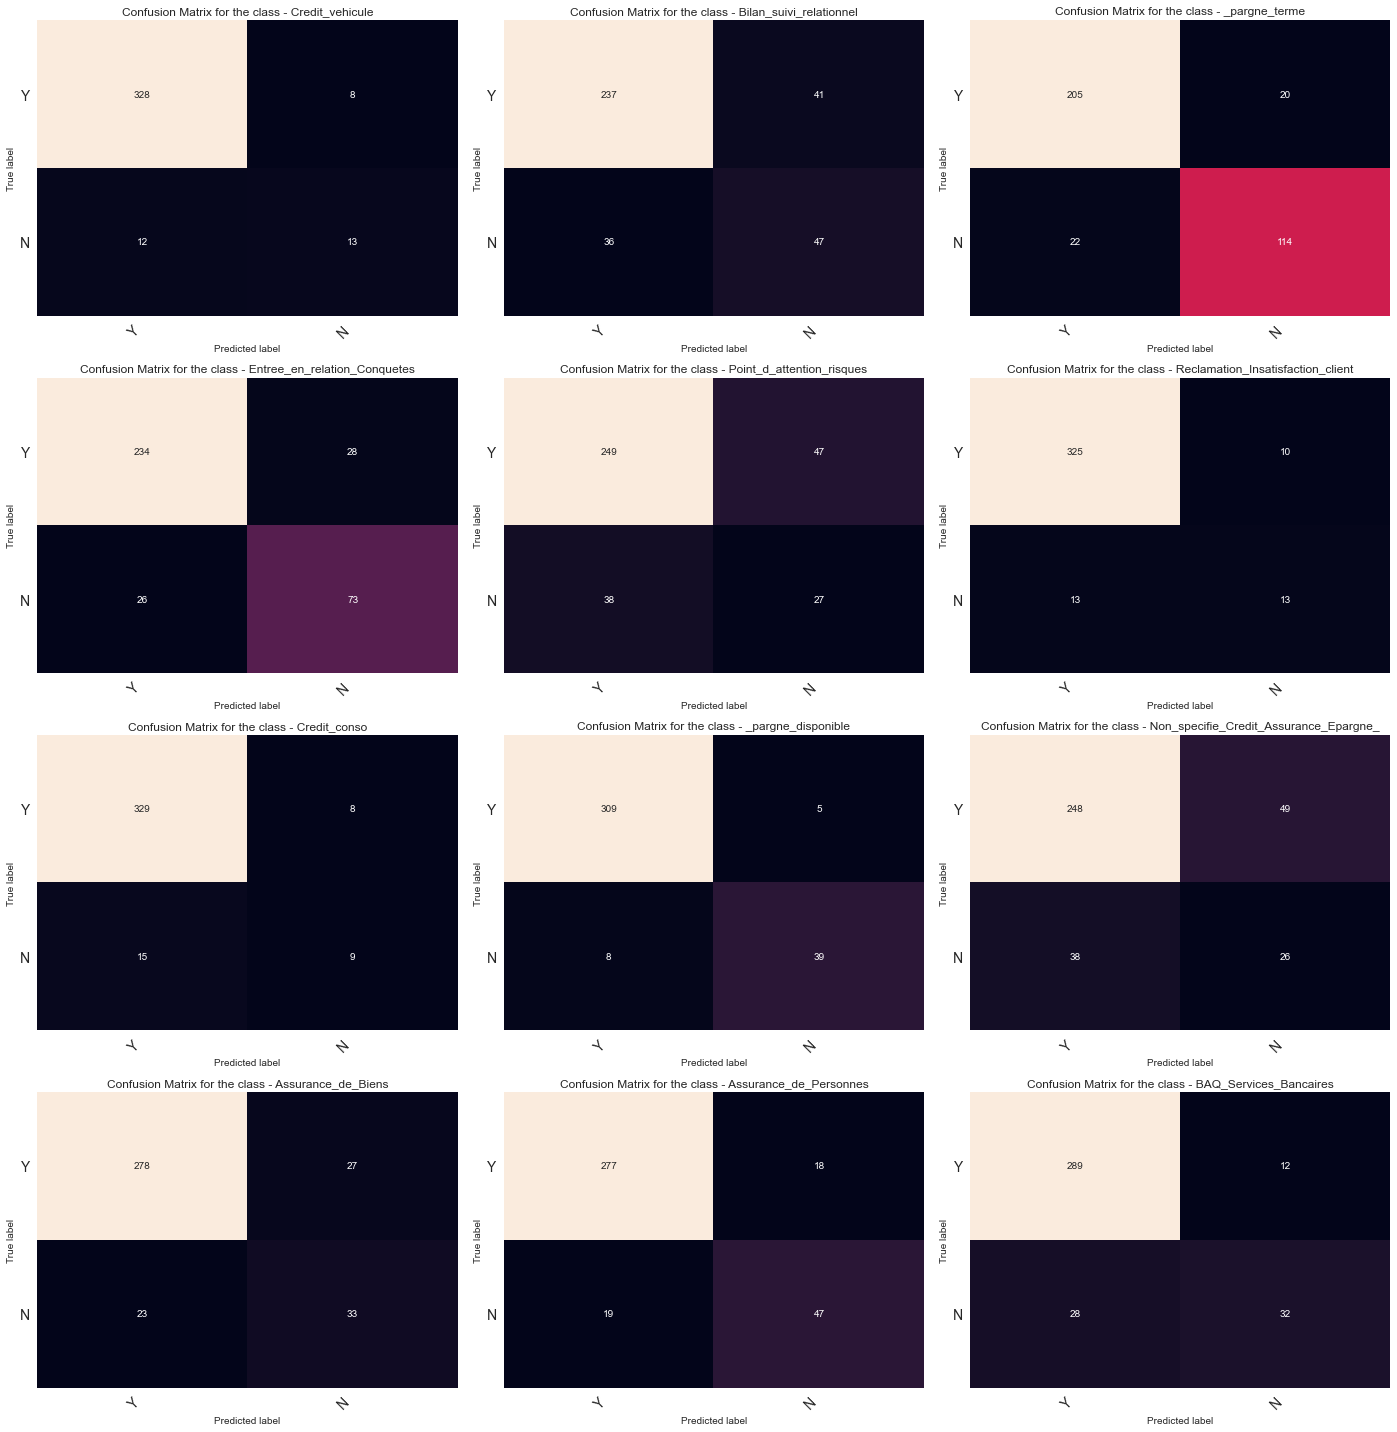

In [30]:
fig, ax = plt.subplots(4, 3, figsize=(20, 20))
    
for axes, cfs_matrix, label in zip(ax.flatten(), confusion, df_s[category_cols]):
        print_confusion_matrix(cfs_matrix, axes, label, ["Y", "N"])
    
fig.tight_layout()
plt.show()

## hyper paramere decision tree

In [26]:
predict_decision_tree2 = pipe_decision_tree2.predict(X_test)

In [27]:
from sklearn import metrics
print(metrics.classification_report(y_test, predict_decision_tree2, target_names=category_cols))

                                        precision    recall  f1-score   support

                       Credit_vehicule       0.55      0.38      0.45        29
               Bilan_suivi_relationnel       0.54      0.41      0.47        82
                         _pargne_terme       0.77      0.78      0.78       118
          Entree_en_relation_Conquetes       0.66      0.77      0.71        84
             Point_d_attention_risques       0.51      0.43      0.47        84
     Reclamation_Insatisfaction_client       0.41      0.63      0.49        35
                          Credit_conso       0.68      0.53      0.60        32
                    _pargne_disponible       0.85      0.82      0.84        56
Non_specifie_Credit_Assurance_Epargne_       0.39      0.46      0.42        70
                    Assurance_de_Biens       0.74      0.67      0.70        63
                Assurance_de_Personnes       0.76      0.78      0.77        64
                BAQ_Services_Bancaires 

In [28]:
score_decision_tree2 = pipe_decision_tree.score(X_test, y_test)
score_decision_tree2

0.14049586776859505

In [62]:
predict_decision_tree2

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 1, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 1, 0],
       ...,
       [0, 1, 1, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 1, ..., 0, 0, 0]])

# Sauvegarde du model

In [33]:
joblib.dump(pipe_decision_tree, 'model_decision_tree.pkl')
print("Model dumped!")

Model dumped!


In [34]:
model_decision_tree = joblib.load('model_decision_tree.pkl')

In [35]:
print(model_decision_tree)

Pipeline(steps=[('countvectorizer', CountVectorizer()),
                ('tfidftransformer', TfidfTransformer()),
                ('multioutputclassifier',
                 MultiOutputClassifier(estimator=DecisionTreeClassifier(random_state=0)))])


# Sauvegarde du df 

In [37]:
df.to_csv(r'C:/Users/ET03349/Desktop/Sémantique/Lot_voix_ca/lot_7.csv',index=False)